In [1]:
import torchvision
import torchvision.transforms as transforms
from LSH_reduction import * 
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

### Model definition

In [11]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, block=BasicBlock, num_classes=10):
        super(ResNet18, self).__init__()

        # ResNet18_hybrid definition
        num_blocks = [2, 2, 2, 2]
        self.in_planes = 64
        self.resnet18 = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                self._make_layer(block, 64, num_blocks[0], stride=1),
                self._make_layer(block, 128, num_blocks[1], stride=2),
                self._make_layer(block, 256, num_blocks[2], stride=2),
                self._make_layer(block, 512, num_blocks[3], stride=2),
                nn.AvgPool2d(4),
                nn.Flatten(1),
                nn.Linear(512*block.expansion, num_classes)
            )

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.resnet18(x)
        return out

### Training and testing functions

In [4]:
# Training module
def train(epoch, net, criterion, optimizer, trainloader, device):
#     print(f'\nEpoch: {epoch}')
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
#     print(batch_idx, len(trainloader),
#                  'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#                  % (train_loss / (batch_idx + 1), 100. * correct / total, correct, total))
    
    return 100. * correct / total
    
# Testing module
def test(epoch, net, criterion, testloader, device):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            
            
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

#         print(batch_idx, len(testloader),
#                      'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#                      % (test_loss / (batch_idx + 1), 100. * correct / total, correct, total))
        return 100. * correct / total

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [5]:
def std_accs(rp, net, testloader):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in rp.label_to_reps}
    total_pred = {classname: 0 for classname in rp.label_to_reps}

    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.cuda())
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[label.item()] += 1
                total_pred[label.item()] += 1

    # print accuracy for each class
    accs = [100 * float(correct_count) / total_pred[classname] for classname, correct_count in sorted(correct_pred.items())]
    accs = np.array(accs)
    return np.nanstd(accs)

In [6]:
def accuracy_time(rp, p, shrinkage = 'LSH'):
    global trainset
    global testset
    t0 = time.time()
    
    if p == 0:
        trainset_reduced = trainset
    elif shrinkage == 'LSH':
        ixs_shrinked = shrink(rp, p)
        trainset_reduced = torch.utils.data.Subset(trainset, ixs_shrinked)
#         print(f'Training on {len(trainset_reduced)} data points.')
    else:
        full_data_size = rp.array.shape[0]
        ixs_shrinked = np.random.randint(low = 0, high = full_data_size, size = int(full_data_size*(1-p)))
        trainset_reduced = torch.utils.data.Subset(trainset, ixs_shrinked)
    
    trainloader = torch.utils.data.DataLoader(
        trainset_reduced, batch_size=128, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=128, shuffle=False, num_workers=2)
    
    device = 'cuda:0'
    num_epochs = 70
    lr = 0.001

    net = ResNet18(BasicBlock, num_classes=100)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    
    for epoch in range(1, num_epochs+1):
        train_acc = train(epoch, net, criterion, optimizer, trainloader, device=device)
        test_acc = test(epoch, net, criterion, testloader, device=device)
        scheduler.step()
    
    return test_acc, time.time() - t0, std_accs(rp, net, testloader)

### Data download and testing

In [7]:
# CIFAR100 Dataloader
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

print(f'Length of trainset: {len(trainset)}, length of testset: {len(testset)}')

Files already downloaded and verified
Files already downloaded and verified
Length of trainset: 50000, length of testset: 10000


In [9]:
rp = Random_projection_hash(trainset)
rp.hash_values()
rp.estimation()

Using: 8 bits, 3 hash tables


In [12]:
n_reps = 5
max_p = 90

acc_res_lsh = []
time_res_lsh = []
std_res_lsh = []

acc_res_random = []
time_res_random = []
std_res_random = []

for p in range(int((max_p + 10)/100)):
    total_acc_lsh = 0
    total_time_lsh = 0
    total_std_lsh = 0
    
    total_acc_random = 0
    total_time_random = 0
    total_std_random = 0
    
    for _ in range(n_reps):
        local_res = accuracy_time(rp, p/10, 'LSH')
        total_acc_lsh += local_res[0]
        total_time_lsh += local_res[1]
        total_std_lsh += local_res[2]
        
        local_res = accuracy_time(rp, p/10, 'random')
        total_acc_random += local_res[0]
        total_time_random += local_res[1]
        total_std_random += local_res[2]
        
    avg_acc_lsh = total_acc_lsh/n_reps
    avg_time_lsh = total_time_lsh/n_reps
    avg_std_lsh = total_std_lsh/n_reps
    print(f'LSH p: {10*p}%  |  {avg_acc_lsh:.5f}  |  {avg_time_lsh:.5f}  |  {avg_std_lsh:.5f}')
    
    acc_res_lsh.append(avg_acc_lsh)
    time_res_lsh.append(avg_time_lsh)
    std_res_lsh.append(avg_std_lsh)
    
    avg_acc_random = total_acc_random/n_reps
    avg_time_random = total_time_random/n_reps
    avg_std_random = total_std_random/n_reps
    print(f'RND p: {10*p}%  |  {avg_acc_random:.5f}  |  {avg_time_random:.5f}  |  {avg_std_random:.5f}\n')
    
    acc_res_random.append(avg_acc_random)
    time_res_random.append(avg_time_random)
    std_res_random.append(avg_std_random)

KeyboardInterrupt: 

In [17]:
acc_res_lsh = np.array(acc_res_lsh)
std_res_lsh = np.array(std_res_lsh)

acc_res_random = np.array(acc_res_random)
std_res_random = np.array(std_res_random)

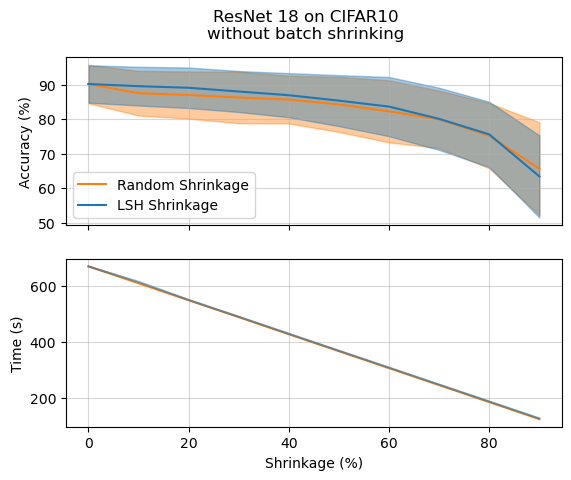

In [18]:
fig, ax = plt.subplots(2,1, sharex = True)
p = [10*i for i in range(int((max_p + 10)/100))]

a = 1/2*(acc_res_random[0] + acc_res_lsh[0])
acc_res_random[0] = a
acc_res_lsh[0] = a

ax[0].grid(alpha = 0.5)
ax[1].grid(alpha = 0.5)

ax[0].plot(p, acc_res_random, c = 'tab:orange', label = 'Random Shrinkage')
ax[0].fill_between(p, acc_res_random - std_res_random, acc_res_random + std_res_random, color = 'tab:orange', alpha = 0.4)
ax[0].plot(p, acc_res_lsh, c = 'tab:blue', label = 'LSH Shrinkage')
ax[0].fill_between(p, acc_res_lsh - std_res_lsh, acc_res_lsh + std_res_lsh, color = 'tab:blue', alpha = 0.4)
ax[0].set_ylabel('Accuracy (%)')

ax[1].plot(p, time_res_random, c = 'tab:orange')
ax[1].plot(p, time_res_lsh, c = 'tab:blue', alpha = 0.6)
ax[1].set_ylabel('Time (s)')

ax[0].legend(loc = 'lower left')
ax[1].set_xlabel('Shrinkage (%)')
_ = fig.suptitle('ResNet 18 on CIFAR10\nwithout batch shrinking')
plt.savefig('ResNet_18_on_CIFAR10.png')